In [ ]:
import gc
del df, df_full, X, y, X_train, y_train, X_val_list, y_val_list
gc.collect()

In [ ]:
import cx_Oracle
import pandas as pd


In [ ]:

conn =  cx_Oracle.connect(user="pc",password="p201404",dsn="siatchdesa")
query = "select * from L_VM_COMPLETA where product_id in (select product_id from L_PRODUCTOS_A_PREDECIR ) and PERIODO <= 201910" 
df = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM

# Para concatenar todos los chunks en un solo DataFrame (si tienes suficiente RAM)
df_full = pd.concat(df, ignore_index=True)
conn.close()
print(df_full.shape)
# Imprimir los tipos de datos de las columnas del DataFrame completo
print(df_full.dtypes)

In [ ]:
# Guardar el DataFrame completo en un archivo CSV
df_full.to_csv("df_full.csv", index=False, encoding='utf-8')

In [ ]:
# Cargar en memoria el DataFrame completo desde el archivo CSV
df_full = pd.read_csv("./data/l_vm_completa_train.csv", encoding='utf-8')


In [ ]:

# Imprimir el menor y el mayor valor de cada columna numérica
print(df_full.describe().loc[['min', 'max']])

In [11]:
# Mostrar las primeras filas del DataFrame
df_full.head()

# Mostrar los nombres de las columnas del DataFrame y sus tipos de datos
df_full.dtypes


periodo                     int64
anio                        int64
mes                         int64
trimestre                   int64
id_cat1                  category
id_cat2                  category
id_cat3                  category
id_brand                 category
sku_size                    int64
customer_id                 int64
product_id                  int64
plan_precios_cuidados    category
cust_request_qty            int64
cust_request_tn           float64
tn                        float64
stock_final               float64
media_movil_3m            float64
desvio_movil_3m           float64
tn_lag_01                 float64
tn_lag_02                 float64
tn_lag_03                 float64
tn_lag_06                 float64
tn_lag_12                 float64
clase                     float64
clase_delta               float64
ordinal                     int64
tn_delta_01               float64
tn_delta_02               float64
tn_delta_03               float64
tn_delta_06   

In [ ]:
# Variables categóricas
# categorical_features = ['CUSTOMER_ID','PRODUCT_ID','ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['id_cat1','id_cat2','id_cat3','id_brand','plan_precios_cuidados']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')
# Asegurarse de que las variables predictoras y objetivo estén en el formato correcto
# Imprimir los tipos de datos de las columnas del DataFrame completo
print(df_full.dtypes)
# Imprimir los nombre de columnas del DataFrame 
print(df_full.columns)

In [12]:
# Usando este código como base para un modelo de regresión con LightGBM
# definir las variables predictoras y la variable objetivo indicando al modelo que las variables categóricas son de tipo 'category'

# Variables predictoras y objetivo
X = df_full[['ordinal', 'periodo', 'anio', 'mes', 'trimestre', 'id_cat1', 'id_cat2',
       'id_cat3', 'id_brand', 'sku_size', 'customer_id', 'product_id',
       'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn',
       'tn', 'stock_final', 'media_movil_3m','desvio_movil_3m', 'tn_lag_01', 'tn_lag_02', 'tn_lag_03', 'tn_lag_06',
       'tn_lag_12', 'tn_delta_01',
       'tn_delta_02', 'tn_delta_03', 'tn_delta_06', 'tn_delta_12']]
y = df_full['clase']


In [14]:
# Definir los periodos de validación 201909, 201910
periodos_valid = [201910]


# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['periodo'] < periodos_valid[0]]
y_train = y[X['periodo'] < periodos_valid[0]]

X_val_list = [X[X['periodo'] == p] for p in periodos_valid]
y_val_list = [y[X['periodo'] == p] for p in periodos_valid]



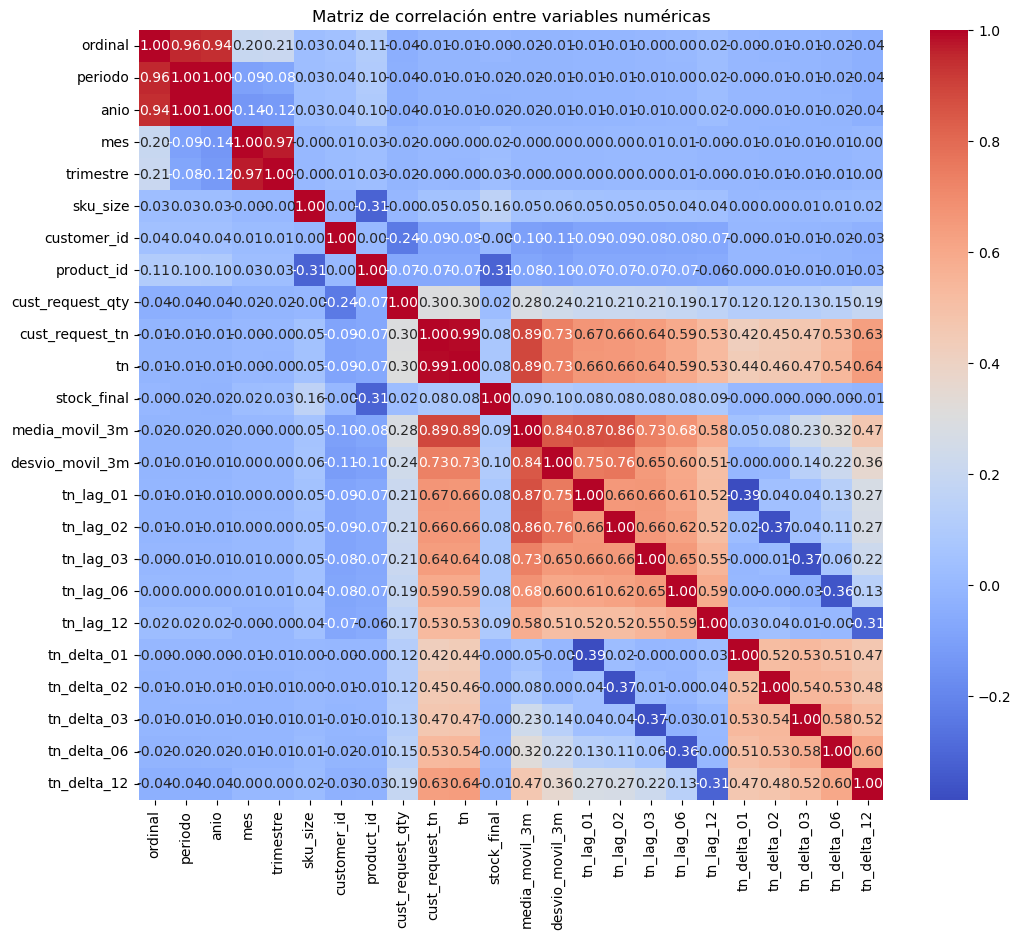

Pares de variables con correlación fuerte (> 0.7):
periodo          anio               0.999172
anio             periodo            0.999172
tn               cust_request_tn    0.993745
cust_request_tn  tn                 0.993745
mes              trimestre          0.968048
trimestre        mes                0.968048
periodo          ordinal            0.955531
ordinal          periodo            0.955531
anio             ordinal            0.942741
ordinal          anio               0.942741
tn               media_movil_3m     0.887426
media_movil_3m   tn                 0.887426
cust_request_tn  media_movil_3m     0.886804
media_movil_3m   cust_request_tn    0.886804
tn_lag_01        media_movil_3m     0.869571
media_movil_3m   tn_lag_01          0.869571
                 tn_lag_02          0.860366
tn_lag_02        media_movil_3m     0.860366
desvio_movil_3m  media_movil_3m     0.844073
media_movil_3m   desvio_movil_3m    0.844073
tn_lag_02        desvio_movil_3m    0.761895
desv

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Solo selecciona las variables numéricas para la correlación
X_numericas = X.select_dtypes(include=[np.number])

# Calcula la matriz de correlación
corr_matrix = X_numericas.corr()


# Visualiza la matriz de correlación como un mapa de calor
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# Opcional: muestra pares de variables con correlación fuerte
umbral = 0.7
correlaciones_fuertes = corr_matrix.abs().unstack().sort_values(ascending=False)
correlaciones_fuertes = correlaciones_fuertes[(correlaciones_fuertes < 1) & (correlaciones_fuertes > umbral)]
print("Pares de variables con correlación fuerte (> 0.7):")
print(correlaciones_fuertes)

In [ ]:

import lightgbm as lgb

# Crear los datasets de LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data_list = [lgb.Dataset(X_val_list[i], label=y_val_list[i], categorical_feature=categorical_features) for i in range(len(periodos_valid))]

# Definir parámetros para regresión
params = { 
    'objective': 'tweedie',
    'tweedie_variance_power': 1.5,  # Ajustar según la naturaleza de los datos
    'metric':['mae', 'rmse'],  # Monitorea ambas métricas
    'boosting_type': 'gbdt',
    'num_leaves': 2047,
    'learning_rate': 0.0005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'verbose': -1
}

# Entrenar el modelo con validación múltiple y early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=50000,
    valid_sets=val_data_list,
    valid_names=[f'validation_{p}' for p in periodos_valid],
    callbacks=[lgb.early_stopping(stopping_rounds=1000), lgb.log_evaluation(period=500)]
)

print("Modelo de regresión entrenado con cinco conjuntos de validación (uno por cada periodo 201906-201910).")

Training until validation scores don't improve for 1000 rounds
[500]	validation_201910's l1: 0.10738	validation_201910's rmse: 1.16957
[1000]	validation_201910's l1: 0.0883553	validation_201910's rmse: 1.16586
[1500]	validation_201910's l1: 0.0765995	validation_201910's rmse: 1.16132
[2000]	validation_201910's l1: 0.0692099	validation_201910's rmse: 1.15517
[2500]	validation_201910's l1: 0.0644281	validation_201910's rmse: 1.14676
[3000]	validation_201910's l1: 0.0612269	validation_201910's rmse: 1.13542
[3500]	validation_201910's l1: 0.0590252	validation_201910's rmse: 1.12047
[4000]	validation_201910's l1: 0.0574714	validation_201910's rmse: 1.10144


In [ ]:
# Obtener la importancia de cada variable
importancia = model.feature_importance(importance_type='gain')
nombres = X_train.columns

# Crear un DataFrame ordenado por importancia
import pandas as pd
df_importancia = pd.DataFrame({'feature': nombres, 'importance': importancia})
df_importancia = df_importancia.sort_values(by='importance', ascending=False)

# Mostrar las variables más importantes
print(df_importancia)

# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables LightGBM')
plt.xlabel('Importancia')
plt.show()

In [ ]:
# Guardo el modelo entrenado
model.save_model('standarizacion_L_VW_N_COMPLETA.txt')

In [ ]:
# Cargo los datos sobre los que quiero hacer predicciones

conn =  cx_Oracle.connect(user="pc",password="p201404",dsn="siatchdesa")
query = "select * from PC.L_VW_N_COMPLETA where periodo = 201912" 
df_pred = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM

# Para concatenar todos los chunks en un solo DataFrame (si tienes suficiente RAM)
df_pred_full = pd.concat(df_pred, ignore_index=True)
conn.close()

In [ ]:
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_pred_full[col] = df_pred_full[col].astype('category')

# Con el modelo entrenado, hacemos predicciones 
X_pred = df_pred_full[['ORDINAL', 'PERIODO', 'ANIO', 'MES', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2',
       'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'CUSTOMER_ID', 'PRODUCT_ID',
       'PLAN_PRECIOS_CUIDADOS', 'CUST_REQUEST_QTY', 'N_CUST_REQUEST_TN',
       'N_TN', 'N_STOCK_FINAL', 'N_MEDIA_MOVIL_3M', 'VOLAT_REL_3M',
       'N_TN_LAG_01', 'N_TN_LAG_02', 'N_TN_LAG_03', 'N_TN_LAG_06',
       'N_TN_LAG_12', 'N_TN_DELTA_01',
       'N_TN_DELTA_02', 'N_TN_DELTA_03', 'N_TN_DELTA_06', 'N_TN_DELTA_12']]


In [ ]:

predictions = model.predict(X_pred)
# Agregar las predicciones al DataFrame original
df_pred_full['PREDICCIONES'] = predictions
# Imprimir las primeras filas del DataFrame con las predicciones
print(df_pred_full.head())
# Guardar el DataFrame con las predicciones en un archivo CSV
df_pred_full.to_csv('predicciones.csv', index=False)
# Imprimir el número de filas y columnas del DataFrame con las predicciones
print(f"Número de filas: {df_pred_full.shape[0]}, Número de columnas: {df_pred_full.shape[1]} con predicciones.")



In [ ]:
# Cargo los datos sobre los que quiero hacer predicciones

conn =  cx_Oracle.connect(user="pc",password="p201404",dsn="siatchdesa")
query = "select product_id,desvio_tn, media_tn from PC.L_PRODUCTOS join PC.L_PRODUCTOS_A_PREDECIR using(product_id) order by 1" 
df_pred = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM
# Para concatenar todos los chunks en un solo DataFrame (si tienes suficiente RAM)
df_desvios_productos = pd.concat(df_pred, ignore_index=True)
conn.close()
medias = df_desvios_productos.set_index('PRODUCT_ID')['MEDIA_TN'].to_dict()
desvios = df_desvios_productos.set_index('PRODUCT_ID')['DESVIO_TN'].to_dict()
print(desvios)

In [ ]:
# Conectar a la base de datos para actualizar los datos de predicción
conn = cx_Oracle.connect(user="pc", password="p201404", dsn="siatchdesa")
# Crear un cursor para ejecutar las actualizaciones
cursor = conn.cursor()
update_query = """
    UPDATE L_VM_COMPLETA_PREDICCIONES
    SET PREDICCION = NULL
"""
cursor.execute(update_query)
# Hacer commit para aplicar el cambio de NULL
conn.commit()


In [ ]:


# Imprimir mensaje de inicio de actualización
print("Iniciando actualización de la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.")

# Iterar sobre las filas del DataFrame con las predicciones
for index, row in df_pred_full.iterrows():
    periodo = row['PERIODO']
    customer_id = row['CUSTOMER_ID']
    product_id = row['PRODUCT_ID']
    # Invierto la standarizacion de TN tomando la media de TN del dataframe de desvios con los productos
    tn_media = medias[product_id]
    desvio_tn = desvios[product_id]
    # La TN se calcula como la media de TN del dataframe de desvios con los productos
    tn = row['N_TN'] * desvio_tn + tn_media
    # La predicción se calcula como la suma de TN y las predicciones * desvio_tn del dataframe de desvios con los productos
    prediccion = tn + row['PREDICCIONES'] * desvio_tn
    # Actualizar la tabla L_DATOS_PREDICCION con la nueva predicción
    update_query = """
        UPDATE L_VM_COMPLETA_PREDICCIONES
        SET PREDICCION = :prediccion
        WHERE PERIODO = :periodo AND CUSTOMER_ID = :customer_id AND PRODUCT_ID = :product_id
    """
    cursor.execute(update_query, {'prediccion': prediccion, 'periodo': periodo, 'customer_id': customer_id, 'product_id': product_id})  
    # Hacer commit cada 10000 filas para evitar problemas de memoria
    if index % 10000 == 0:
        conn.commit()
        print(f"Actualizadas {index} filas de L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.")
# Confirmar los cambios en la base de datos
conn.commit()
# Cerrar el cursor y la conexión
cursor.close()
conn.close()
# Imprimir mensaje de finalización
print("Actualización de la tabla  completada con las nuevas predicciones.")
